<a href="https://colab.research.google.com/github/Huypham07/evince/blob/main/train_evince.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVINCE: Complete Training Pipeline (Self-Contained)

**Vietnamese Banking ESG-Washing Detection**

This notebook is **fully self-contained** - all code is included.

**Models:**
1. **ESG Topic Classifier** - PhoBERT + Classification Head
2. **Washing Detector** - PhoBERT + Multi-task Head

## 1. Setup

In [1]:
!pip install -q torch transformers pandas scikit-learn tqdm huggingface_hub matplotlib seaborn

In [2]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from typing import Dict, List, Optional, Tuple
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch: 2.9.0+cu126
CUDA: True
GPU: Tesla T4


## 2. Configuration

In [3]:
CONFIG = {
    'data_path': 'labeled.csv',
    'model_name': 'vinai/phobert-base-v2',
    'max_length': 256,  # PhoBERT max = 258
    'batch_size': 16,
    'epochs': 5,
    'learning_rate': 2e-5,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'undersample_ratio': 1.0,
    'output_dir': './checkpoints',
    'hf_username': 'huypham71',
}

# ESG Labels
ESG_LABELS = [
    "Environmental_Performance",
    "Social_Performance",
    "Governance_Performance",
    "ESG_Financing",
    "Strategy_and_Policy",
    "Not_ESG_Related"
]
ESG_LABEL_TO_ID = {label: i for i, label in enumerate(ESG_LABELS)}
ESG_ID_TO_LABEL = {i: label for i, label in enumerate(ESG_LABELS)}

SHORT_TO_FULL = {
    'E': 'Environmental_Performance',
    'S': 'Social_Performance',
    'G': 'Governance_Performance',
    'Financing': 'ESG_Financing',
    'Policy': 'Strategy_and_Policy',
    'Non-ESG': 'Not_ESG_Related',
}

# Washing Labels
WASHING_LABELS = [
    "NO_WASHING",
    "CHERRY_PICKING",
    "VAGUE_CLAIMS",
    "LACK_OF_PROOF",
    "MISLEADING_IMAGERY",
    "FALSE_LABELS",
    "SELECTIVE_DISCLOSURE"
]
WASHING_LABEL_TO_ID = {label: i for i, label in enumerate(WASHING_LABELS)}
WASHING_ID_TO_LABEL = {i: label for i, label in enumerate(WASHING_LABELS)}

print("Configuration loaded")

Configuration loaded


## 3. Model Architectures

In [4]:
class ESGTopicClassifier(nn.Module):
    """
    ESG Topic Classifier using PhoBERT.

    Architecture:
    - PhoBERT encoder (vinai/phobert-base-v2)
    - Dropout (0.3)
    - Linear (768 -> 256)
    - ReLU
    - Dropout (0.2)
    - Linear (256 -> num_classes)
    """

    def __init__(
        self,
        model_name: str = "vinai/phobert-base-v2",
        num_classes: int = 6,
        dropout: float = 0.3,
        freeze_bert_layers: int = 0
    ):
        super().__init__()

        self.num_classes = num_classes

        # Load PhoBERT encoder
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size  # 768

        # Freeze layers if specified
        if freeze_bert_layers > 0:
            for param in self.encoder.embeddings.parameters():
                param.requires_grad = False
            for i, layer in enumerate(self.encoder.encoder.layer):
                if i < freeze_bert_layers:
                    for param in layer.parameters():
                        param.requires_grad = False

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor
    ) -> torch.Tensor:
        """
        Forward pass.

        Args:
            input_ids: Token IDs [batch_size, seq_len]
            attention_mask: Attention mask [batch_size, seq_len]

        Returns:
            logits: [batch_size, num_classes]
        """
        # Create token_type_ids (required for RoBERTa)
        token_type_ids = torch.zeros_like(input_ids)

        # Encode with PhoBERT
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        # Use [CLS] token representation
        cls_output = outputs.last_hidden_state[:, 0, :]

        # Classify
        logits = self.classifier(cls_output)

        return logits

In [5]:
class WashingDetector(nn.Module):
    """
    Washing Detector with multi-task learning.

    Architecture:
    - PhoBERT encoder
    - Shared hidden layer
    - Two heads:
      1. Washing type classifier (7 classes)
      2. Confidence regressor
    """

    def __init__(
        self,
        model_name: str = "vinai/phobert-base-v2",
        num_classes: int = 7,
        dropout: float = 0.3,
        freeze_bert_layers: int = 0
    ):
        super().__init__()

        self.num_classes = num_classes

        # Load PhoBERT encoder
        self.encoder = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.encoder.config.hidden_size

        # Freeze layers if specified
        if freeze_bert_layers > 0:
            for param in self.encoder.embeddings.parameters():
                param.requires_grad = False
            for i, layer in enumerate(self.encoder.encoder.layer):
                if i < freeze_bert_layers:
                    for param in layer.parameters():
                        param.requires_grad = False

        # Shared hidden layer
        self.shared = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # Washing type classifier
        self.type_classifier = nn.Linear(256, num_classes)

        # Confidence regressor (0-1)
        self.confidence_regressor = nn.Sequential(
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass.

        Returns:
            type_logits: [batch_size, num_classes]
            confidence: [batch_size, 1]
        """
        token_type_ids = torch.zeros_like(input_ids)

        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids
        )

        cls_output = outputs.last_hidden_state[:, 0, :]
        shared_output = self.shared(cls_output)

        type_logits = self.type_classifier(shared_output)
        confidence = self.confidence_regressor(shared_output)

        return type_logits, confidence

## 4. Dataset Class

In [6]:
class ESGDataset(Dataset):
    """
    Dataset for ESG/Washing classification.

    Handles:
    - Tokenization with PhoBERT tokenizer
    - Padding/truncation
    - Token ID validation (clamp to vocab range)
    """

    def __init__(
        self,
        sentences: List[str],
        labels: List[int],
        tokenizer_name: str = "vinai/phobert-base-v2",
        max_length: int = 256
    ):
        self.sentences = sentences
        self.labels = labels
        self.max_length = max_length

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.vocab_size = self.tokenizer.vocab_size

        print(f"Dataset: {len(sentences)} samples, vocab={self.vocab_size}, max_len={max_length}")

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx) -> Dict[str, torch.Tensor]:
        sentence = self.sentences[idx]
        label = self.labels[idx]

        # Handle None/invalid sentences
        if sentence is None or not isinstance(sentence, str):
            sentence = ""
        sentence = str(sentence).strip()
        if not sentence:
            sentence = "[UNK]"

        # Tokenize
        encoding = self.tokenizer(
            sentence,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Clamp token IDs to valid range
        input_ids = encoding["input_ids"].squeeze(0)
        input_ids = torch.clamp(input_ids, min=0, max=self.vocab_size - 1)

        return {
            "input_ids": input_ids,
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

## 5. Trainer Class

In [7]:
class Trainer:
    """
    Training loop with:
    - Weighted CrossEntropyLoss (for imbalanced data)
    - AdamW optimizer with weight decay
    - Linear warmup scheduler
    - Checkpoint saving
    - Validation evaluation
    """

    def __init__(
        self,
        model: nn.Module,
        train_loader: DataLoader,
        val_loader: DataLoader,
        learning_rate: float = 2e-5,
        weight_decay: float = 0.01,
        num_epochs: int = 5,
        warmup_ratio: float = 0.1,
        output_dir: str = "./checkpoints",
        device: str = "cuda",
        class_weights: torch.Tensor = None
    ):
        self.device = torch.device(device)
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        self.output_dir = output_dir
        os.makedirs(output_dir, exist_ok=True)

        # Optimizer
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_params = [
            {"params": [p for n, p in model.named_parameters()
                       if not any(nd in n for nd in no_decay)],
             "weight_decay": weight_decay},
            {"params": [p for n, p in model.named_parameters()
                       if any(nd in n for nd in no_decay)],
             "weight_decay": 0.0},
        ]
        self.optimizer = AdamW(optimizer_params, lr=learning_rate)

        # Scheduler
        total_steps = len(train_loader) * num_epochs
        warmup_steps = int(total_steps * warmup_ratio)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer, warmup_steps, total_steps
        )

        # Loss function
        if class_weights is not None:
            class_weights = class_weights.to(self.device)
            self.criterion = nn.CrossEntropyLoss(weight=class_weights)
            print("Using weighted CrossEntropyLoss")
        else:
            self.criterion = nn.CrossEntropyLoss()

        self.best_val_acc = 0.0
        self.history = {"train_loss": [], "val_loss": [], "val_acc": []}

    def train_epoch(self, epoch: int) -> float:
        self.model.train()
        total_loss = 0.0

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.num_epochs}")
        for batch in pbar:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            self.optimizer.zero_grad()

            outputs = self.model(input_ids, attention_mask)

            # Handle multi-task output
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            loss = self.criterion(logits, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)

            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})

        return total_loss / len(self.train_loader)

    @torch.no_grad()
    def evaluate(self) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        for batch in self.val_loader:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            outputs = self.model(input_ids, attention_mask)
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            loss = self.criterion(logits, labels)
            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        return {
            "val_loss": total_loss / len(self.val_loader),
            "val_acc": correct / total
        }

    @torch.no_grad()
    def evaluate_loader(self, data_loader: DataLoader) -> Dict[str, float]:
        """Evaluate on any DataLoader (for test set)."""
        self.model.eval()
        total_loss = 0.0
        all_preds = []
        all_labels = []

        for batch in data_loader:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)

            outputs = self.model(input_ids, attention_mask)
            if isinstance(outputs, tuple):
                logits = outputs[0]
            else:
                logits = outputs

            loss = self.criterion(logits, labels)
            total_loss += loss.item()

            preds = logits.argmax(dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        return {
            "loss": total_loss / len(data_loader),
            "accuracy": accuracy_score(all_labels, all_preds),
            "f1_macro": f1_score(all_labels, all_preds, average='macro'),
            "f1_weighted": f1_score(all_labels, all_preds, average='weighted')
        }

    def save_checkpoint(self, epoch: int, is_best: bool = False):
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "best_val_acc": self.best_val_acc,
        }
        torch.save(checkpoint, f"{self.output_dir}/checkpoint_latest.pt")
        if is_best:
            torch.save(checkpoint, f"{self.output_dir}/checkpoint_best.pt")

    def train(self):
        print(f"Training on {self.device}")
        print(f"Epochs: {self.num_epochs}, Batch size: {self.train_loader.batch_size}")

        for epoch in range(self.num_epochs):
            train_loss = self.train_epoch(epoch)
            val_metrics = self.evaluate()

            self.history["train_loss"].append(train_loss)
            self.history["val_loss"].append(val_metrics["val_loss"])
            self.history["val_acc"].append(val_metrics["val_acc"])

            print(f"  Train Loss: {train_loss:.4f}")
            print(f"  Val Loss: {val_metrics['val_loss']:.4f}, Val Acc: {val_metrics['val_acc']:.4f}")

            is_best = val_metrics["val_acc"] > self.best_val_acc
            if is_best:
                self.best_val_acc = val_metrics["val_acc"]
                print(f"  New best! Saving checkpoint...")

            self.save_checkpoint(epoch, is_best)

        print(f"\nTraining complete. Best Val Acc: {self.best_val_acc:.4f}")

## 6. Load Data

In [8]:
# Upload data/labeled.csv or use your path
df = pd.read_csv(CONFIG['data_path'])
text_col = 'text' if 'text' in df.columns else 'sentence'

print(f"Dataset: {len(df)} samples")
print(f"\nLabel distribution:")
print(df['esg_label'].value_counts())

FileNotFoundError: [Errno 2] No such file or directory: 'labeled.csv'

---
# Part A: Train ESG Classifier
---

In [27]:
# Prepare ESG data with balancing
df_esg = df[df['esg_label'].notna()].copy()
df_esg['label_mapped'] = df_esg['esg_label'].map(lambda x: SHORT_TO_FULL.get(x, x))
df_esg = df_esg[df_esg['label_mapped'].isin(ESG_LABELS)].reset_index(drop=True)

# Undersample Non-ESG
label_counts = df_esg['esg_label'].value_counts()
second_largest = label_counts.iloc[1]
max_non_esg = int(second_largest * CONFIG['undersample_ratio'])

df_non_esg = df_esg[df_esg['esg_label'] == 'Non-ESG']
df_other = df_esg[df_esg['esg_label'] != 'Non-ESG']

if len(df_non_esg) > max_non_esg:
    df_non_esg = df_non_esg.sample(n=max_non_esg, random_state=42)

df_esg_balanced = pd.concat([df_other, df_non_esg]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Balanced: {len(df_esg_balanced)} samples")
print(df_esg_balanced['esg_label'].value_counts())

Balanced: 19299 samples
esg_label
G            7588
Non-ESG      7588
S            2726
Financing     688
E             399
Policy        310
Name: count, dtype: int64


In [28]:
# Class weights
label_counts_bal = df_esg_balanced['label_mapped'].value_counts()
total = len(df_esg_balanced)
n_classes = len(ESG_LABELS)

esg_class_weights = {}
for label in ESG_LABELS:
    count = label_counts_bal.get(label, 1)
    esg_class_weights[ESG_LABEL_TO_ID[label]] = total / (n_classes * count)

esg_weight_tensor = torch.tensor([esg_class_weights[i] for i in range(n_classes)], dtype=torch.float)
print("Class weights:", esg_class_weights)

Class weights: {0: np.float64(8.06140350877193), 1: np.float64(1.1799339691856199), 2: np.float64(0.4238929889298893), 3: np.float64(4.6751453488372094), 4: np.float64(10.375806451612902), 5: np.float64(0.4238929889298893)}


In [29]:
# Stratified split
texts = df_esg_balanced[text_col].tolist()
labels = [ESG_LABEL_TO_ID[l] for l in df_esg_balanced['label_mapped']]

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

print(f"Train: {len(train_texts)}, Val: {len(val_texts)}, Test: {len(test_texts)}")

Train: 15439, Val: 1930, Test: 1930


In [30]:
# Create datasets
esg_train_dataset = ESGDataset(train_texts, train_labels, max_length=CONFIG['max_length'])
esg_val_dataset = ESGDataset(val_texts, val_labels, max_length=CONFIG['max_length'])
esg_test_dataset = ESGDataset(test_texts, test_labels, max_length=CONFIG['max_length'])

esg_train_loader = DataLoader(esg_train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
esg_val_loader = DataLoader(esg_val_dataset, batch_size=CONFIG['batch_size'])
esg_test_loader = DataLoader(esg_test_dataset, batch_size=CONFIG['batch_size'])

Dataset: 15439 samples, vocab=64000, max_len=256
Dataset: 1930 samples, vocab=64000, max_len=256
Dataset: 1930 samples, vocab=64000, max_len=256


In [31]:
# Initialize model
esg_model = ESGTopicClassifier(num_classes=6)

total_params = sum(p.numel() for p in esg_model.parameters())
trainable = sum(p.numel() for p in esg_model.parameters() if p.requires_grad)
print(f"Total params: {total_params:,}")
print(f"Trainable: {trainable:,}")

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total params: 135,196,678
Trainable: 135,196,678


In [32]:
# Train
esg_trainer = Trainer(
    model=esg_model,
    train_loader=esg_train_loader,
    val_loader=esg_val_loader,
    learning_rate=CONFIG['learning_rate'],
    num_epochs=CONFIG['epochs'],
    output_dir=f"{CONFIG['output_dir']}/esg",
    device=str(DEVICE),
    class_weights=esg_weight_tensor
)

esg_trainer.train()

Using weighted CrossEntropyLoss
Training on cuda
Epochs: 5, Batch size: 16


Epoch 1/5:   0%|          | 0/965 [00:00<?, ?it/s]

  Train Loss: 1.2349
  Val Loss: 0.7441, Val Acc: 0.8518
  New best! Saving checkpoint...


Epoch 2/5:   0%|          | 0/965 [00:00<?, ?it/s]

  Train Loss: 0.6013
  Val Loss: 0.5118, Val Acc: 0.8886
  New best! Saving checkpoint...


Epoch 3/5:   0%|          | 0/965 [00:00<?, ?it/s]

  Train Loss: 0.4311
  Val Loss: 0.5193, Val Acc: 0.8969
  New best! Saving checkpoint...


Epoch 4/5:   0%|          | 0/965 [00:00<?, ?it/s]

  Train Loss: 0.3043
  Val Loss: 0.5055, Val Acc: 0.9073
  New best! Saving checkpoint...


Epoch 5/5:   0%|          | 0/965 [00:00<?, ?it/s]

  Train Loss: 0.2242
  Val Loss: 0.5620, Val Acc: 0.9088
  New best! Saving checkpoint...

Training complete. Best Val Acc: 0.9088


In [33]:
# Evaluate on test set
esg_test_metrics = esg_trainer.evaluate_loader(esg_test_loader)

print("\n" + "="*50)
print("ESG CLASSIFIER - TEST RESULTS")
print("="*50)
print(f"Accuracy: {esg_test_metrics['accuracy']:.4f}")
print(f"F1 Macro: {esg_test_metrics['f1_macro']:.4f}")
print(f"F1 Weighted: {esg_test_metrics['f1_weighted']:.4f}")


ESG CLASSIFIER - TEST RESULTS
Accuracy: 0.9114
F1 Macro: 0.8347
F1 Weighted: 0.9118


In [34]:
# Classification report
esg_model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in esg_test_loader:
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        outputs = esg_model(input_ids, attention_mask)
        preds = outputs.argmax(dim=-1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(batch['labels'].numpy())

label_names = [l.replace('_Performance', '').replace('_Related', '') for l in ESG_LABELS]
print(classification_report(all_labels, all_preds, target_names=label_names, digits=3))

                     precision    recall  f1-score   support

      Environmental      0.762     0.800     0.780        40
             Social      0.894     0.897     0.896       273
         Governance      0.924     0.928     0.926       759
      ESG_Financing      0.765     0.912     0.832        68
Strategy_and_Policy      0.645     0.645     0.645        31
            Not_ESG      0.941     0.917     0.929       759

           accuracy                          0.911      1930
          macro avg      0.822     0.850     0.835      1930
       weighted avg      0.913     0.911     0.912      1930



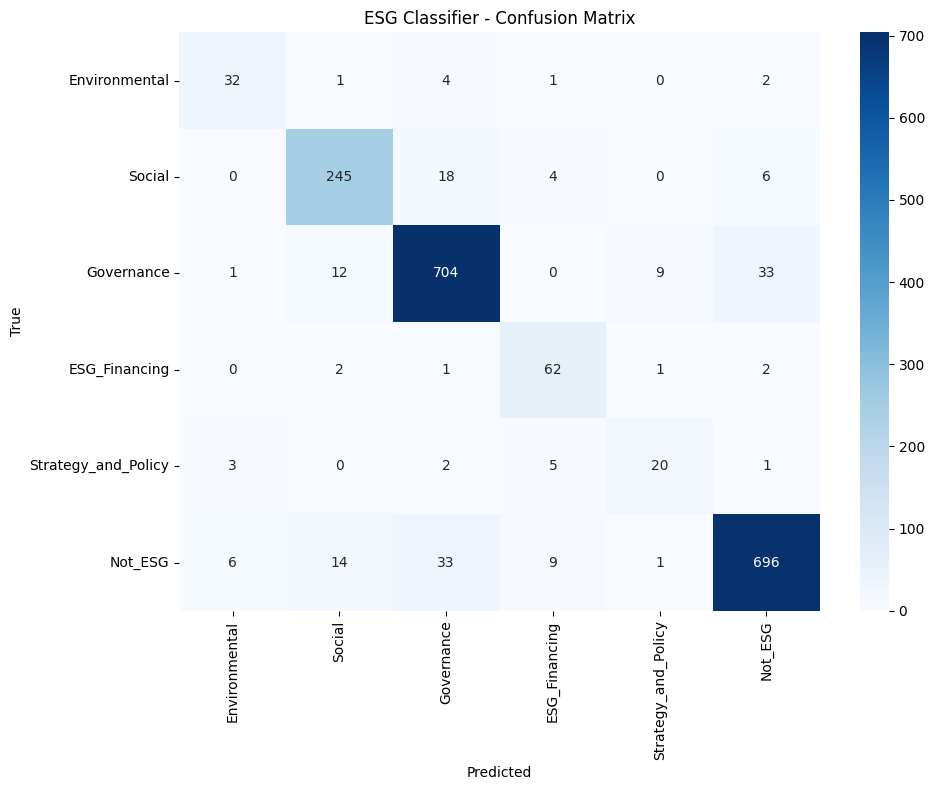

In [35]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('ESG Classifier - Confusion Matrix')
plt.tight_layout()
plt.show()

---
# Part B: Train Washing Detector (Optional)
---

In [37]:
# Check if washing data exists
if 'washing_type' in df.columns:
    df_washing = df[df['esg_label'] != 'Non-ESG'].copy()
    df_washing = df_washing[df_washing['washing_type'].notna()]
    df_washing = df_washing[df_washing['washing_type'].isin(WASHING_LABELS)].reset_index(drop=True)

    print(f"Washing samples: {len(df_washing)}")
    TRAIN_WASHING = len(df_washing) >= 100
else:
    print("No washing_type column found")
    TRAIN_WASHING = False

Washing samples: 35


In [38]:
if TRAIN_WASHING:
    # Prepare washing data
    w_texts = df_washing[text_col].tolist()
    w_labels = [WASHING_LABEL_TO_ID[l] for l in df_washing['washing_type']]

    w_train_texts, w_temp_texts, w_train_labels, w_temp_labels = train_test_split(
        w_texts, w_labels, test_size=0.2, random_state=42, stratify=w_labels
    )
    w_val_texts, w_test_texts, w_val_labels, w_test_labels = train_test_split(
        w_temp_texts, w_temp_labels, test_size=0.5, random_state=42, stratify=w_temp_labels
    )

    # Create datasets
    w_train_dataset = ESGDataset(w_train_texts, w_train_labels, max_length=CONFIG['max_length'])
    w_val_dataset = ESGDataset(w_val_texts, w_val_labels, max_length=CONFIG['max_length'])
    w_test_dataset = ESGDataset(w_test_texts, w_test_labels, max_length=CONFIG['max_length'])

    w_train_loader = DataLoader(w_train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
    w_val_loader = DataLoader(w_val_dataset, batch_size=CONFIG['batch_size'])
    w_test_loader = DataLoader(w_test_dataset, batch_size=CONFIG['batch_size'])

    # Class weights
    w_counts = df_washing['washing_type'].value_counts()
    w_weights = {}
    for label in WASHING_LABELS:
        count = w_counts.get(label, 1)
        w_weights[WASHING_LABEL_TO_ID[label]] = len(df_washing) / (len(WASHING_LABELS) * count)
    w_weight_tensor = torch.tensor([w_weights[i] for i in range(len(WASHING_LABELS))], dtype=torch.float)

    # Train
    washing_model = WashingDetector(num_classes=7)

    washing_trainer = Trainer(
        model=washing_model,
        train_loader=w_train_loader,
        val_loader=w_val_loader,
        learning_rate=CONFIG['learning_rate'],
        num_epochs=CONFIG['epochs'],
        output_dir=f"{CONFIG['output_dir']}/washing",
        device=str(DEVICE),
        class_weights=w_weight_tensor
    )

    washing_trainer.train()

    # Evaluate
    w_test_metrics = washing_trainer.evaluate_loader(w_test_loader)
    print(f"\nWashing Detector - Accuracy: {w_test_metrics['accuracy']:.4f}, F1: {w_test_metrics['f1_macro']:.4f}")
else:
    print("Skipping Washing Detector training")

Skipping Washing Detector training


---
# Part C: Upload to HuggingFace
---

In [39]:
from huggingface_hub import HfApi, login
login()

In [36]:
# Save and upload ESG model
esg_save_path = f"{CONFIG['output_dir']}/esg/hf"
os.makedirs(esg_save_path, exist_ok=True)

torch.save({
    'model_state_dict': esg_model.state_dict(),
    'config': {'model_name': CONFIG['model_name'], 'num_classes': 6, 'max_length': CONFIG['max_length']},
    'label_mapping': ESG_LABEL_TO_ID,
    'test_metrics': esg_test_metrics
}, f"{esg_save_path}/pytorch_model.bin")

# Model card
with open(f"{esg_save_path}/README.md", 'w') as f:
    f.write(f"""---
language: vi
tags: [esg, text-classification, vietnamese, phobert]
---
# ESG Topic Classifier (Vietnamese)
Accuracy: {esg_test_metrics['accuracy']:.4f}, F1 Macro: {esg_test_metrics['f1_macro']:.4f}
""")

api = HfApi()
ESG_REPO = f"{CONFIG['hf_username']}/evince-esg-classifier-v2"
api.create_repo(repo_id=ESG_REPO, exist_ok=True)
api.upload_folder(folder_path=esg_save_path, repo_id=ESG_REPO)
print(f"Uploaded: https://huggingface.co/{ESG_REPO}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  .../esg/hf/pytorch_model.bin:   0%|          | 2.20MB /  541MB            

Uploaded: https://huggingface.co/huypham71/evince-esg-classifier-v2


In [40]:
# Upload Washing model if trained
if TRAIN_WASHING:
    w_save_path = f"{CONFIG['output_dir']}/washing/hf"
    os.makedirs(w_save_path, exist_ok=True)

    torch.save({
        'model_state_dict': washing_model.state_dict(),
        'config': {'model_name': CONFIG['model_name'], 'num_classes': 7},
        'label_mapping': WASHING_LABEL_TO_ID,
        'test_metrics': w_test_metrics
    }, f"{w_save_path}/pytorch_model.bin")

    WASHING_REPO = f"{CONFIG['hf_username']}/evince-washing-detector-v2"
    api.create_repo(repo_id=WASHING_REPO, exist_ok=True)
    api.upload_folder(folder_path=w_save_path, repo_id=WASHING_REPO)
    print(f"Uploaded: https://huggingface.co/{WASHING_REPO}")

## Done!

Models uploaded to HuggingFace Hub.